In [28]:
import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from imageio import imsave
from torch.utils import model_zoo

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model,
    adjust_model,
)
from building_footprint_segmentation.utils.operations import handle_image_size

In [29]:
MAX_SIZE = 384
TRAINED_MODEL = ReFineNet()
MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"

PRED_PTH = r"path/to/input_image.png"

In [30]:
def set_model_weights():
    state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    if "model" in state_dict:
        state_dict = state_dict["model"]
    TRAINED_MODEL.load_state_dict(adjust_model(state_dict))


def extract(original_image):
    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        prediction = TRAINED_MODEL(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )
    return prediction_binary, prediction_3_channels, dst


In [33]:
def run(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    set_model_weights()
    # PARALLELIZE the model if gpu available
    # model = load_parallel_model(model)

    prediction_binary, prediction_3_channels, dst = extract(original_image)
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    return prediction_binary, prediction_3_channels, dst

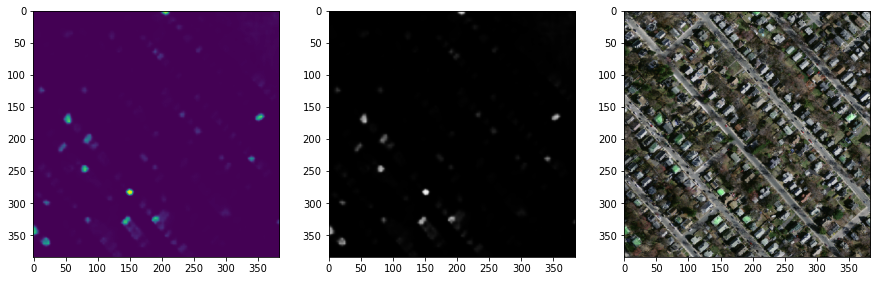

In [38]:
pred = run(PRED_PTH)

fig,ax = plt.subplots(1,3,figsize = (15,15))
ax = ax.ravel()
for i in range(3):
  image = pred[i]
  ax[i].imshow(image)  
plt.show()